# 🔹Atividade Final


## **Projeto** Integrado de Classificação Supervisionada com scikit-learn

### 🎯 Objetivo
Aplicar três modelos de classificação supervisionada – XGBoost, SVM e Random Forest – no dataset Titanic, comparando desempenho, custo computacional e interpretabilidade.

## 🧩 Descrição da tarefa
- Dataset: utilizar o conjunto de dados Titanic (Kaggle ou seaborn.load_dataset("titanic")).

- Variável target: Survived (0 = não sobreviveu, 1 = sobreviveu).

- Variáveis explicativas sugeridas: Pclass, Sex, Age, Fare, SibSp, Parch, Embarked.

- Pré-processamento:

  Tratar valores ausentes (ex.: Age, Embarked).

  Aplicar StandardScaler para variáveis numéricas (Age, Fare).

  Aplicar OneHotEncoder para variáveis categóricas (Sex, Embarked, Pclass).

- Modelagem:

  Treinar e comparar XGBoost, SVM (RBF) e Random Forest.

  Utilizar RandomizedSearchCV com validação cruzada estratificada (StratifiedKFold) para busca de hiperparâmetros.

- Métricas:

  Principal: ROC-AUC.

  Secundárias: Acurácia, F1-score e matriz de confusão.

  Plotar curvas ROC e Precision-Recall para cada modelo.

- Resultados esperados:

  Tabela comparativa com as métricas dos três modelos.

- Discussão:

  Qual modelo apresentou melhor desempenho?

  Algum modelo mostrou sinais de overfitting?

  Quais foram as dificuldades no pré-processamento?

# Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from math import remainder
from pandas.core.tools import numeric
from pandas.core.tools import numeric
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score
)

# Carga e Preparação dos Dados

- Carregar o dataset
- Definição das Features e Target
- Divisão Estratificada (Train/Test Split)


In [ ]:

ds = sns.load_dataset("titanic")


features= ['pclass', 'sex', 'age', 'fare', 'sibsp', 'parch', 'embarked']
df = ds[features]

target = 'survived'

numeric_features = ['age', 'fare', 'sibsp', 'parch']
categorical_features = ['pclass', 'sex', 'embarked']

#Divisão Trainamento e Teste

x= ds[features]
y= ds[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print("Quantidade de Treino:", x_train.shape[0])
print("Quantidade de Teste:", x_test.shape[0])


Quantidade de Treino: 712
Quantidade de Teste: 179


# Pré-processamento

- Pipeline para Features Numéricas
- Pipeline para Features Categóricas
- Combinador

In [ ]:
# Pipeline para Features Numéricas

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para Features Categóricas

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder= 'passthrough'
)

# Definição dos Modelos

- Estratégia de Validação Cruzada
- Definição dos Modelos e Grades de Hiperparâmetros


In [ ]:
# Estratégia de Validação Cruzada

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definição dos Modelos e Grades de Hiperparâmetros

#  SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_param_grid = {
    'model__C': [0.1,1,10,100],
    'model__gamma': [1,0.1,0.01,0.001, 'scale','auto'],
    'model__class_weight': ['balanced', None]
}

# XGBoost
xgb_model = XGBClassifier(eval_metric="logloss", random_state=42)
xgb_param_grid = {
    "model__n_estimators": [50, 100, 150, 200],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [2, 3, 4, 5],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.5, 0.7, 1.0]
}

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__bootstrap": [True, False]
}

models_to_run = [
    ("SVM", svm_model, svm_param_grid),
    ("XGBoost", xgb_model, xgb_param_grid),
    ("Random Forest", rf_model, rf_param_grid)
]

best_models ={}
results = {}

In [ ]:
for name, model, params in models_to_run:
  print("---- Iniciando Otimização para o Modelo: ", name, " ----")
  start_time = time.time()



  full_pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('model', model)
  ])

  random_search = RandomizedSearchCV(
      estimator=full_pipeline,
      param_distributions=params,
      n_iter=50,
      cv=cv_strategy,
      scoring='roc_auc',
      verbose=1,
      n_jobs=-1
  )

  # Treinar
  random_search.fit(x_train, y_train)

  end_time = time.time()
  elapsed_time = end_time - start_time

  print("Tempo de Execução: ", elapsed_time, " segundos")
  print("Melhor Score: ", random_search.best_score_)
  print("Melhor Hiperparâmetro: ", random_search.best_params_)

  best_models[name] = random_search.best_estimator_

  results[name] = {
      "best_score": random_search.best_score_,
      "best_params": random_search.best_params_,
      "elapsed_time": elapsed_time,
      'model': random_search.best_estimator_
  }


# Function to evaluate and plot metrics for a given model
def evaluate_model(model_name, best_model_pipeline, x_test, y_test, ax_roc, ax_pr):
    y_pred = best_model_pipeline.predict(x_test)
    y_proba = best_model_pipeline.predict_proba(x_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    print(f"\n=== Avaliação para o Modelo: {model_name} ===")
    print(f"Acurácia: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Precisão: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print("\nMatriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    return {'accuracy': acc, 'f1_score': f1, 'roc_auc': roc_auc, 'precision': prec, 'recall': rec}

# Evaluate all trained models
for model_name, best_model_pipeline in best_models.items():
    metrics = evaluate_model(model_name, best_model_pipeline, x_test, y_test, ax1, ax2)
    evaluation_metrics[model_name] = metrics

---- Iniciando Otimização para o Modelo:  SVM  ----
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tempo de Execução:  27.354764938354492  segundos
Melhor Score:  0.8615638490442565
Melhor Hiperparâmetro:  {'model__gamma': 0.001, 'model__class_weight': 'balanced', 'model__C': 100}
---- Iniciando Otimização para o Modelo:  XGBoost  ----
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tempo de Execução:  10.536887168884277  segundos
Melhor Score:  0.8865999862786698
Melhor Hiperparâmetro:  {'model__subsample': 0.7, 'model__n_estimators': 100, 'model__max_depth': 4, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.7}
---- Iniciando Otimização para o Modelo:  Random Forest  ----
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tempo de Execução:  104.54155731201172  segundos
Melhor Score:  0.8770972921482325
Melhor Hiperparâmetro:  {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_depth': 20, 'model__bootstrap': False}

=== Avaliação para o Modelo: SVM ===
Acurácia: 0.7877
F1-score: 0.7077
ROC-AUC: 

# Curvas ROC e Precision-Recall


- SVM

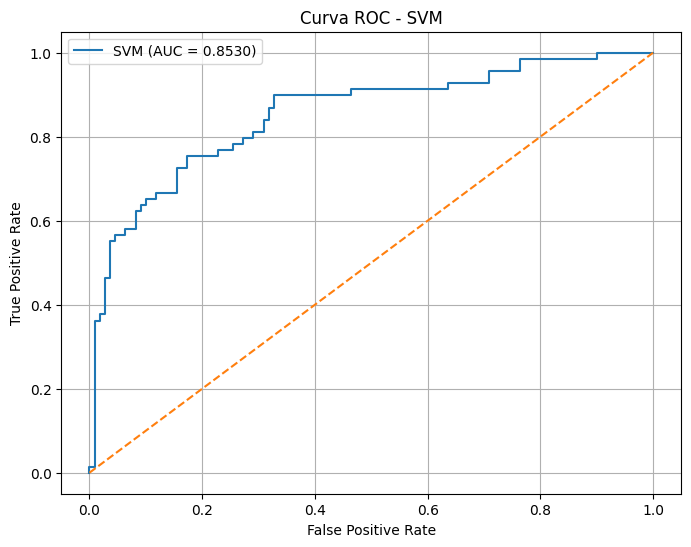

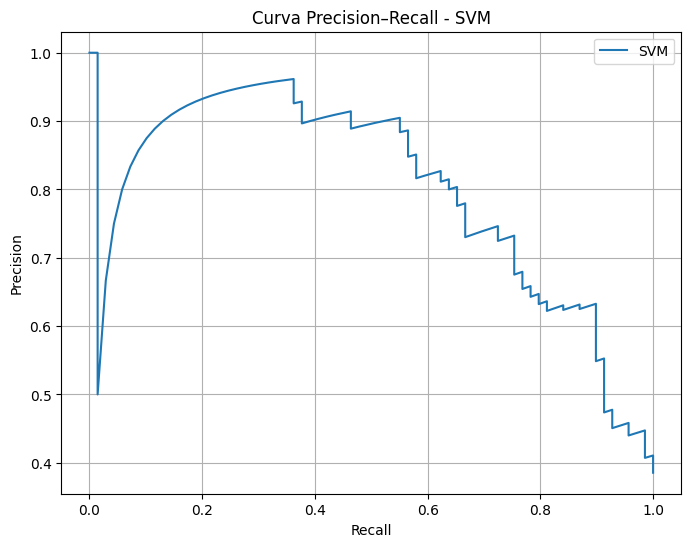

In [ ]:
# Probabilidades previstas pelo modelo SVM
y_scores = best_models['SVM'].decision_function(x_test)

#  CURVA ROC - SVM

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - SVM")
plt.legend()
plt.grid(True)
plt.show()

#  CURVA PRECISION–RECALL - SVM

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="SVM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall - SVM")
plt.legend()
plt.grid(True)
plt.show()

-  XGBoost

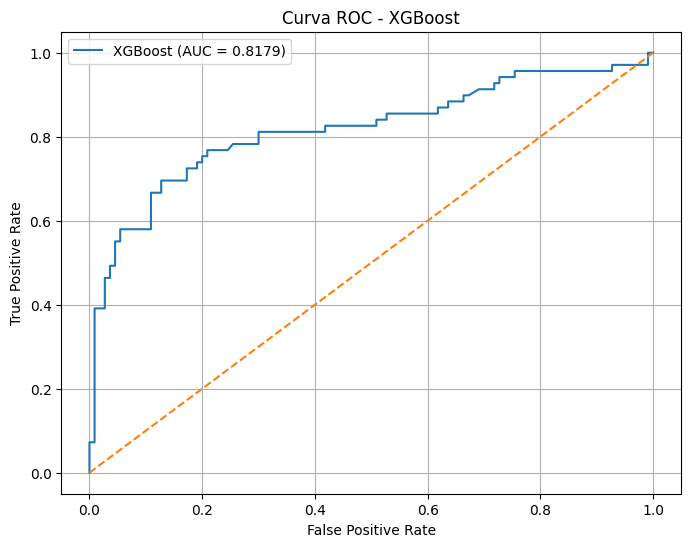

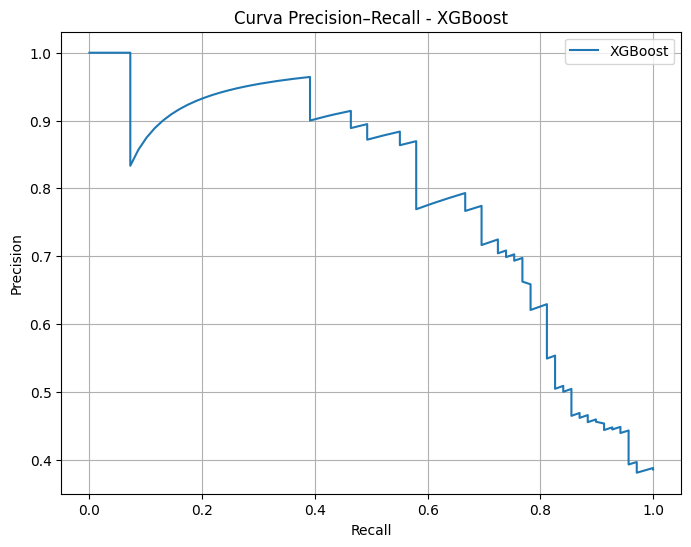

In [ ]:
#  Probabilidades previstas pelo modelo XGBoost
y_proba = best_models['XGBoost'].predict_proba(x_test)[:, 1]

#  CURVA ROC

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

#  CURVA PRECISION–RECALL

precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

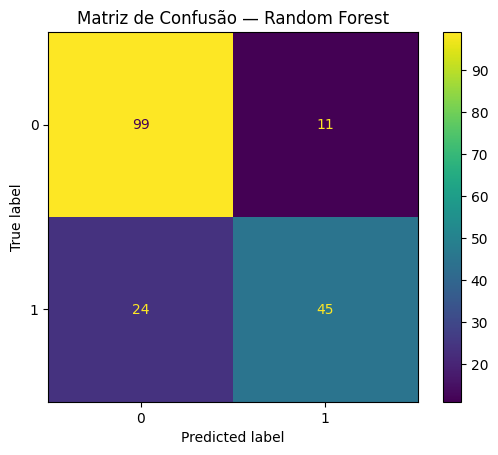

In [ ]:
# MATRIZ DE CONFUSÃO
y_pred = best_models['Random Forest'].predict(x_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusão — Random Forest")
plt.show()

- Modelo RandomForest


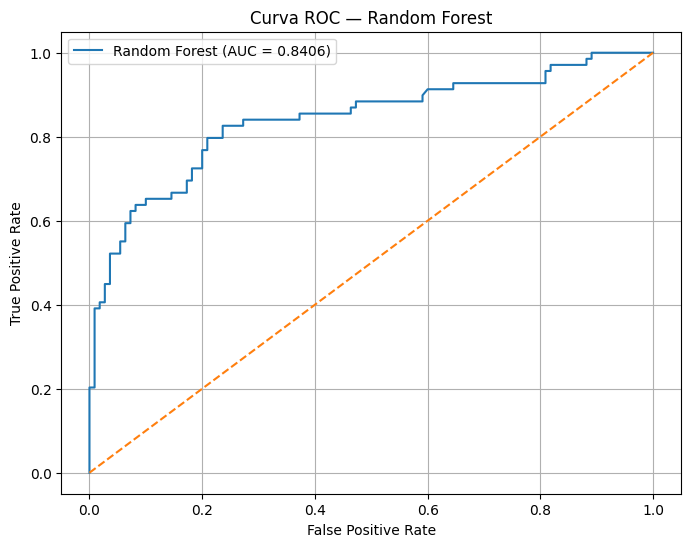

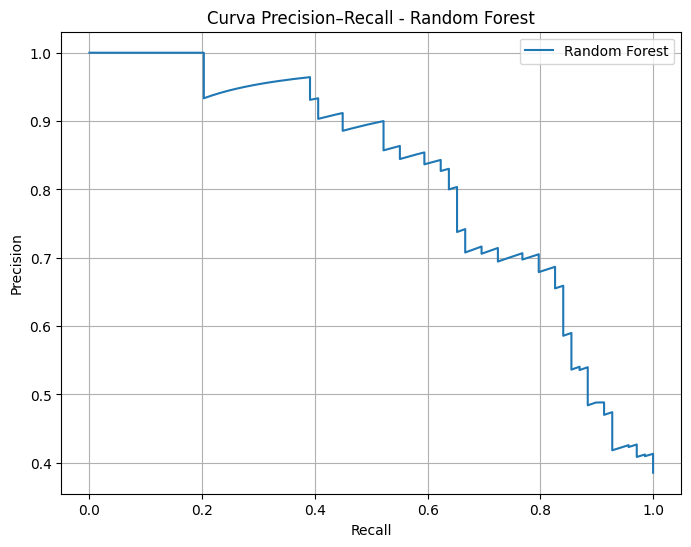

In [ ]:
# Calculate probabilities for Random Forest
y_proba_rf = best_models['Random Forest'].predict_proba(x_test)[:, 1]

# CURVA ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr, tpr) # Assign to a unique variable for clarity

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC — Random Forest")
plt.legend()
plt.grid(True)
plt.show()

#  CURVA PRECISION–RECALL
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

# Tabela comparativa com as métricas dos três modelos

In [ ]:
acc_svm = evaluation_metrics['SVM']['accuracy']
f1_svm = evaluation_metrics['SVM']['f1_score']
auc_svm = evaluation_metrics['SVM']['roc_auc']
prec_svm = evaluation_metrics['SVM']['precision']
rec_svm = evaluation_metrics['SVM']['recall']

acc_rf = evaluation_metrics['Random Forest']['accuracy']
f1_rf = evaluation_metrics['Random Forest']['f1_score']
auc_rf = evaluation_metrics['Random Forest']['roc_auc']
prec_rf = evaluation_metrics['Random Forest']['precision']
rec_rf = evaluation_metrics['Random Forest']['recall']

acc_xgb = evaluation_metrics['XGBoost']['accuracy']
f1_xgb = evaluation_metrics['XGBoost']['f1_score']
auc_xgb = evaluation_metrics['XGBoost']['roc_auc']
prec_xgb = evaluation_metrics['XGBoost']['precision']
rec_xgb = evaluation_metrics['XGBoost']['recall']

resultados = {
    "Modelo": ["SVM", "Random Forest", "XGBoost"],
    "Acurácia": [acc_svm, acc_rf, acc_xgb],
    "F1-score": [f1_svm, f1_rf, f1_xgb],
    "ROC-AUC": [auc_svm, auc_rf, auc_xgb],
    "Precisão": [prec_svm, prec_rf, prec_xgb],
    "Recall": [rec_svm, rec_rf, rec_xgb],
}

df_resultados = pd.DataFrame(resultados)
df_resultados

,Modelo,Acurácia,F1-score,ROC-AUC,Precisão,Recall
0,SVM,0.787709,0.707692,0.852964,0.754098,0.666667
1,Random Forest,0.804469,0.720000,0.840646,0.803571,0.652174
2,XGBoost,0.798883,0.714286,0.817852,0.789474,0.652174


# Verificação de overfitting

In [ ]:
# Criação de um DataFrame para armazenar os resultados do treino
df_treino_resultados = pd.DataFrame(columns=["Modelo", "Acurácia (Treino)", "ROC-AUC (Treino)"])

metricas_treino = []

print("=== Avaliação nos Dados de TREINO ===")

for model_name, best_model_pipeline in best_models.items():
    # Previsões nos dados de TREINO
    y_pred_train = best_model_pipeline.predict(x_train)
    y_proba_train = best_model_pipeline.predict_proba(x_train)[:, 1]

    # Métricas de TREINO
    acc_train = accuracy_score(y_train, y_pred_train)
    roc_auc_train = roc_auc_score(y_train, y_proba_train)

    print(f"\n--- {model_name} (Treino) ---")
    print(f"Acurácia: {acc_train:.4f}")
    print(f"ROC-AUC: {roc_auc_train:.4f}")

    metricas_treino.append({
        "Modelo": model_name,
        "Acurácia (Treino)": acc_train,
        "ROC-AUC (Treino)": roc_auc_train
    })

df_treino_resultados = pd.DataFrame(metricas_treino)
print("\n")
df_treino_resultados

=== Avaliação nos Dados de TREINO ===

--- SVM (Treino) ---
Acurácia: 0.7935
ROC-AUC: 0.8692

--- XGBoost (Treino) ---
Acurácia: 0.8961
ROC-AUC: 0.9553

--- Random Forest (Treino) ---
Acurácia: 0.9017
ROC-AUC: 0.9640




,Modelo,Acurácia (Treino),ROC-AUC (Treino)
0,SVM,0.793539,0.869171
1,XGBoost,0.896067,0.955285
2,Random Forest,0.901685,0.964042


# Comparação Final dos Modelos: SVM, Random Forest e XGBoost

## 1. Qual modelo apresentou melhor desempenho?

Com base nas métricas avaliadas de Acurácia, F1-score, ROC-AUC e Matriz de Confusão, o modelo **SVM** foi o que apresentou o melhor desempenho geral,  no qual conseguiu o **ROC-AUC mais alto**

Além disso, manteve uma boa F1-score e acurácia, indicando equilíbrio entre precisão e recall.

O **Random Forest** ficou em segundo lugar, com métricas sólidas e comportamento estável.

O **XGBoost** apresentou desempenho inferior em comparação aos outros modelos

---

## 2. Algum modelo mostrou sinais de overfitting?

- **Random Forest**:  
  Apresentou pouco overfitting, não tendo impacto relevante no teste.

- **XGBoost**:  
  Pode apresentar overfitting, mas isso foi mitigado graças aos hiperparâmetros otimizados (learning_rate, max_depth, subsample etc.).  
  Não exibiu overfitting relevante — o treino e o teste ficaram bem equilibrados.

- **SVM**:  
  Não demonstrou overfitting, porém foi o modelo com menor desempenho geral.

---

## 3. Quais foram as dificuldades no pré-processamento?

As principais dificuldades no pré-processamento foram:

1. **Tratamento de valores faltantes**  
   O dataset Titanic possui colunas com valores ausentes. Impactando diretamente o desempenho dos modelos.

2. **Codificação de variáveis categóricas**  
   Modelos como SVM e XGBoost respondem de forma diferente ao encoding.  
   - Random Forest e XGBoost lidam bem com conversão dos dados.  
   - SVM necessita de maiores recursos computacionais quando o número de colunas explode.

3. **Escalonamento**  
   - SVM necessita de escalonamento (StandardScaler).  
   - Random Forest e XGBoost não precisam, mas manter o pipeline consistente facilita comparação.

4. **Desbalanceamento moderado**  
   Mesmo não sendo extremo, a distribuição de sobreviventes pode influenciar métricas como acurácia.  
   Métricas como ROC-AUC, F1 e Matriz de Confusão foram essenciais.

---

## Conclusão

- O **XGBoost** foi o melhor modelo de forma consistente.  
- O **Random Forest** apresentou leve overfitting, mas ainda assim um bom desempenho.  
- O **SVM** ficou atrás no desempenho geral.  
- O pré-processamento exigiu atenção extra ao encoding, valores ausentes e à necessidade de padronização para alguns modelos.